In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [ ]:
nltk.download("vader_lexicon", download_dir="./.venv/nltk_data")

In [6]:
df = pd.read_csv("./Reviews.csv")
sub_df = df.head(500)

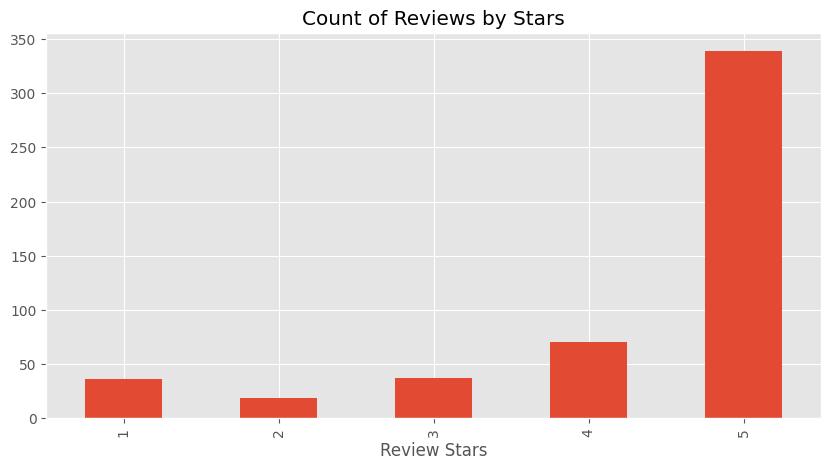

In [7]:
ax = sub_df["Score"].value_counts() \
                .sort_index() \
                .plot(kind="bar", 
                      title="Count of Reviews by Stars", 
                      figsize=(10,5))
ax.set_xlabel("Review Stars")
plt.show()

In [8]:
example = sub_df["Text"][50]
example

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [9]:
tokens = nltk.word_tokenize(example) # NLTK uses PunktSentenceTokenizer
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [10]:
pos_tags = nltk.pos_tag(tokens) # Part of speech tagging, each word relates to a "part of speech", such as Determiner (What is being addressed), adjective, etc
pos_tags[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [11]:
entities = nltk.chunk.ne_chunk(pos_tags) # Chunking is grouping related words
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Using VADER (Valence Aware Dictionary and sEntiment Reasoner)
- Uses a bag of words approach
  1. Remove stop words (and, the, etc)
  2. Each word is scored and aggregated to a total score

In [12]:
sia = SentimentIntensityAnalyzer()

In [13]:
sia.polarity_scores("I am so happy") # Compound is -1 to 1 to represent the whole sentence

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [14]:
sia.polarity_scores("This is the worst thing ever!")

{'neg': 0.468, 'neu': 0.532, 'pos': 0.0, 'compound': -0.6588}

In [15]:
sia.polarity_scores("This is the best and worst thing ever!")

{'neg': 0.281, 'neu': 0.411, 'pos': 0.308, 'compound': 0.1007}

In [16]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [17]:
res = {}
for i, row in tqdm(sub_df.iterrows(), total=len(sub_df)):
    text = row["Text"]
    curr_id = row["Id"]
    res[curr_id] = sia.polarity_scores(text)


res_df = pd.DataFrame(res).T
res_df = res_df.reset_index().rename({"index": "Id"}, axis=1)
res_df = res_df.merge(sub_df, how="left")

  0%|          | 0/500 [00:00<?, ?it/s]

In [18]:
res_df.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


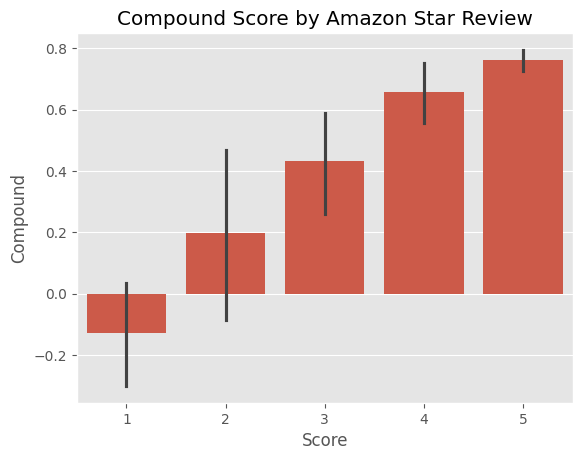

In [19]:
ax = sns.barplot(data=res_df, x="Score", y="compound")
ax.set_title("Compound Score by Amazon Star Review")
ax.set_ylabel("Compound")
plt.show()

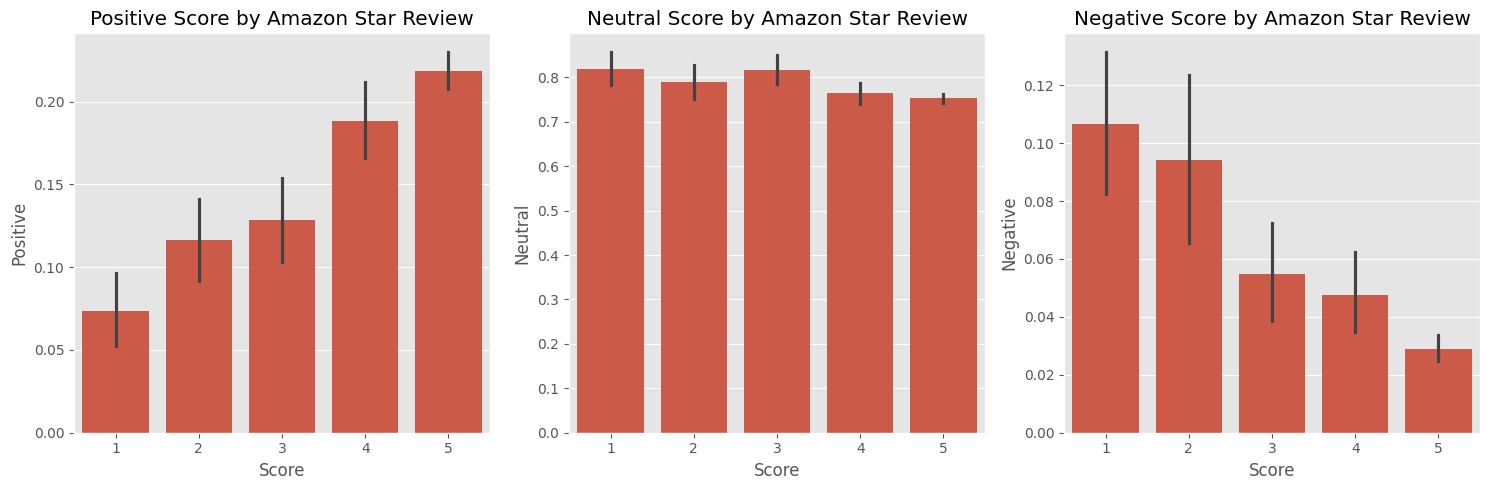

In [20]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
ax1 = sns.barplot(data=res_df, x="Score", y="pos", ax=axs[0])
ax1.set_title("Positive Score by Amazon Star Review")
ax1.set_ylabel("Positive")
ax2 = sns.barplot(data=res_df, x="Score", y="neu", ax=axs[1])
ax2.set_title("Neutral Score by Amazon Star Review")
ax2.set_ylabel("Neutral")
ax2 = sns.barplot(data=res_df, x="Score", y="neg", ax=axs[2])
ax2.set_title("Negative Score by Amazon Star Review")
ax2.set_ylabel("Negative")
plt.tight_layout()
plt.show()

As mentioned before, VADER scores individual words and not group of words as a whole! -> Take for example, if a comment was meant to be sarcastic and imply goodness, VADER will not be able to pick up on this context and mark the sentiment as negative

## Transformer-based models (Roberta pretrained)

- Use a model trained off a large corpus of data
- Transformer model accounts for the words but also the context related to other words

In [31]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from typing import Dict, Any

In [2]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [23]:
# VADER EX RESULTS
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [29]:
# Roberta results
tokens = tokenizer(example, return_tensors="pt")
output = model(**tokens)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
score_dict = {
    "roberta_neg": scores[0],
    "roberta_neu": scores[1],
    "roberta_pos": scores[2]
}
score_dict

{'roberta_neg': np.float32(0.97635514),
 'roberta_neu': np.float32(0.020687465),
 'roberta_pos': np.float32(0.0029573706)}

Comparing the two, intuitively we can see that the review is negative, but VADER might perceive words like mushy, soft as neutral while the context of the sentence makes it negative

In [ ]:
def polarity_scores_roberta(input: str) -> Dict[str, Any]:
    encoded_text = tokenizer(input, return_tensors="pt")
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    score_dict = {
        "roberta_neg": scores[0],
        "roberta_neu": scores[1],
        "roberta_pos": scores[2]
    }
    return score_dict

In [41]:
vader_res = {}
roberta_res = {}
for i, row in tqdm(sub_df.iterrows(), total=len(sub_df)):
    try:
        text = row["Text"]
        curr_id = row["Id"]
        vader_res[curr_id] = sia.polarity_scores(text)
        roberta_res[curr_id] = polarity_scores_roberta(text)
    except RuntimeError:
        print(f"Could not run for ID: {curr_id}, Text: {text}")

  0%|          | 0/500 [00:00<?, ?it/s]

Could not run for ID: 83, Text: I know the product title says Molecular Gastronomy, but don't let that scare you off.  I have been looking for this for a while now, not for food science, but for something more down to earth.  I use it to make my own coffee creamer.<br /><br />I have to have my coffee blonde and sweet - but the flavored creamers are full of the bad kinds of fat, and honestly, I hate to use manufactured "food" items.  I really don't think they are good for the body.  On the other hand, I hate using cold milk or cream, because I like HOT coffee.<br /><br />I stumbled across this on Amazon one day and got the idea of making my own creamer.  I also bought low-fat (non-instant) milk powder and regular milk powder. The non-instant lowfat milk is a little sweeter and tastes fresher than regular instant low-fat milk, but does not dissolve good in cold water - which is not a problem for hot coffee.  You will have to play with the ratios - I would not do just the heavy cream, it 

It is noted that transformers are SLOWER on CPU! While VADER takes literal seconds to complete, using ROBERTA introduces a lot of latency. Use of GPU is needed for faster transformer models

In [72]:
vader_res_merged = pd.DataFrame(vader_res).T.reset_index().rename({"index": "Id"}, axis=1).merge(sub_df, how="left")
roberta_res_merged = pd.DataFrame(roberta_res).T.reset_index().rename({"index": "Id"}, axis=1).merge(sub_df, how="left")

In [73]:
res_merged = vader_res_merged.merge(roberta_res_merged, how="left")

In [74]:
res_merged = res_merged.rename({"neg": "vader_neg", "neu": "vader_neu", "pos": "vader_pos"}, axis=1)

In [80]:
new_order = ["Id", "vader_neg", "vader_neu", "vader_pos", "roberta_neg", "roberta_neu", "roberta_pos"]
res_merged_reorder = res_merged[new_order + [col for col in res_merged.columns if col not in new_order]]

In [81]:
res_merged_reorder.head()

,Id,vader_neg,vader_neu,vader_pos,roberta_neg,roberta_neu,roberta_pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.009624,0.049980,0.940395,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,0.508986,0.452414,0.038600,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.003229,0.098067,0.898704,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.002295,0.090219,0.907486,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.001635,0.010302,0.988063,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


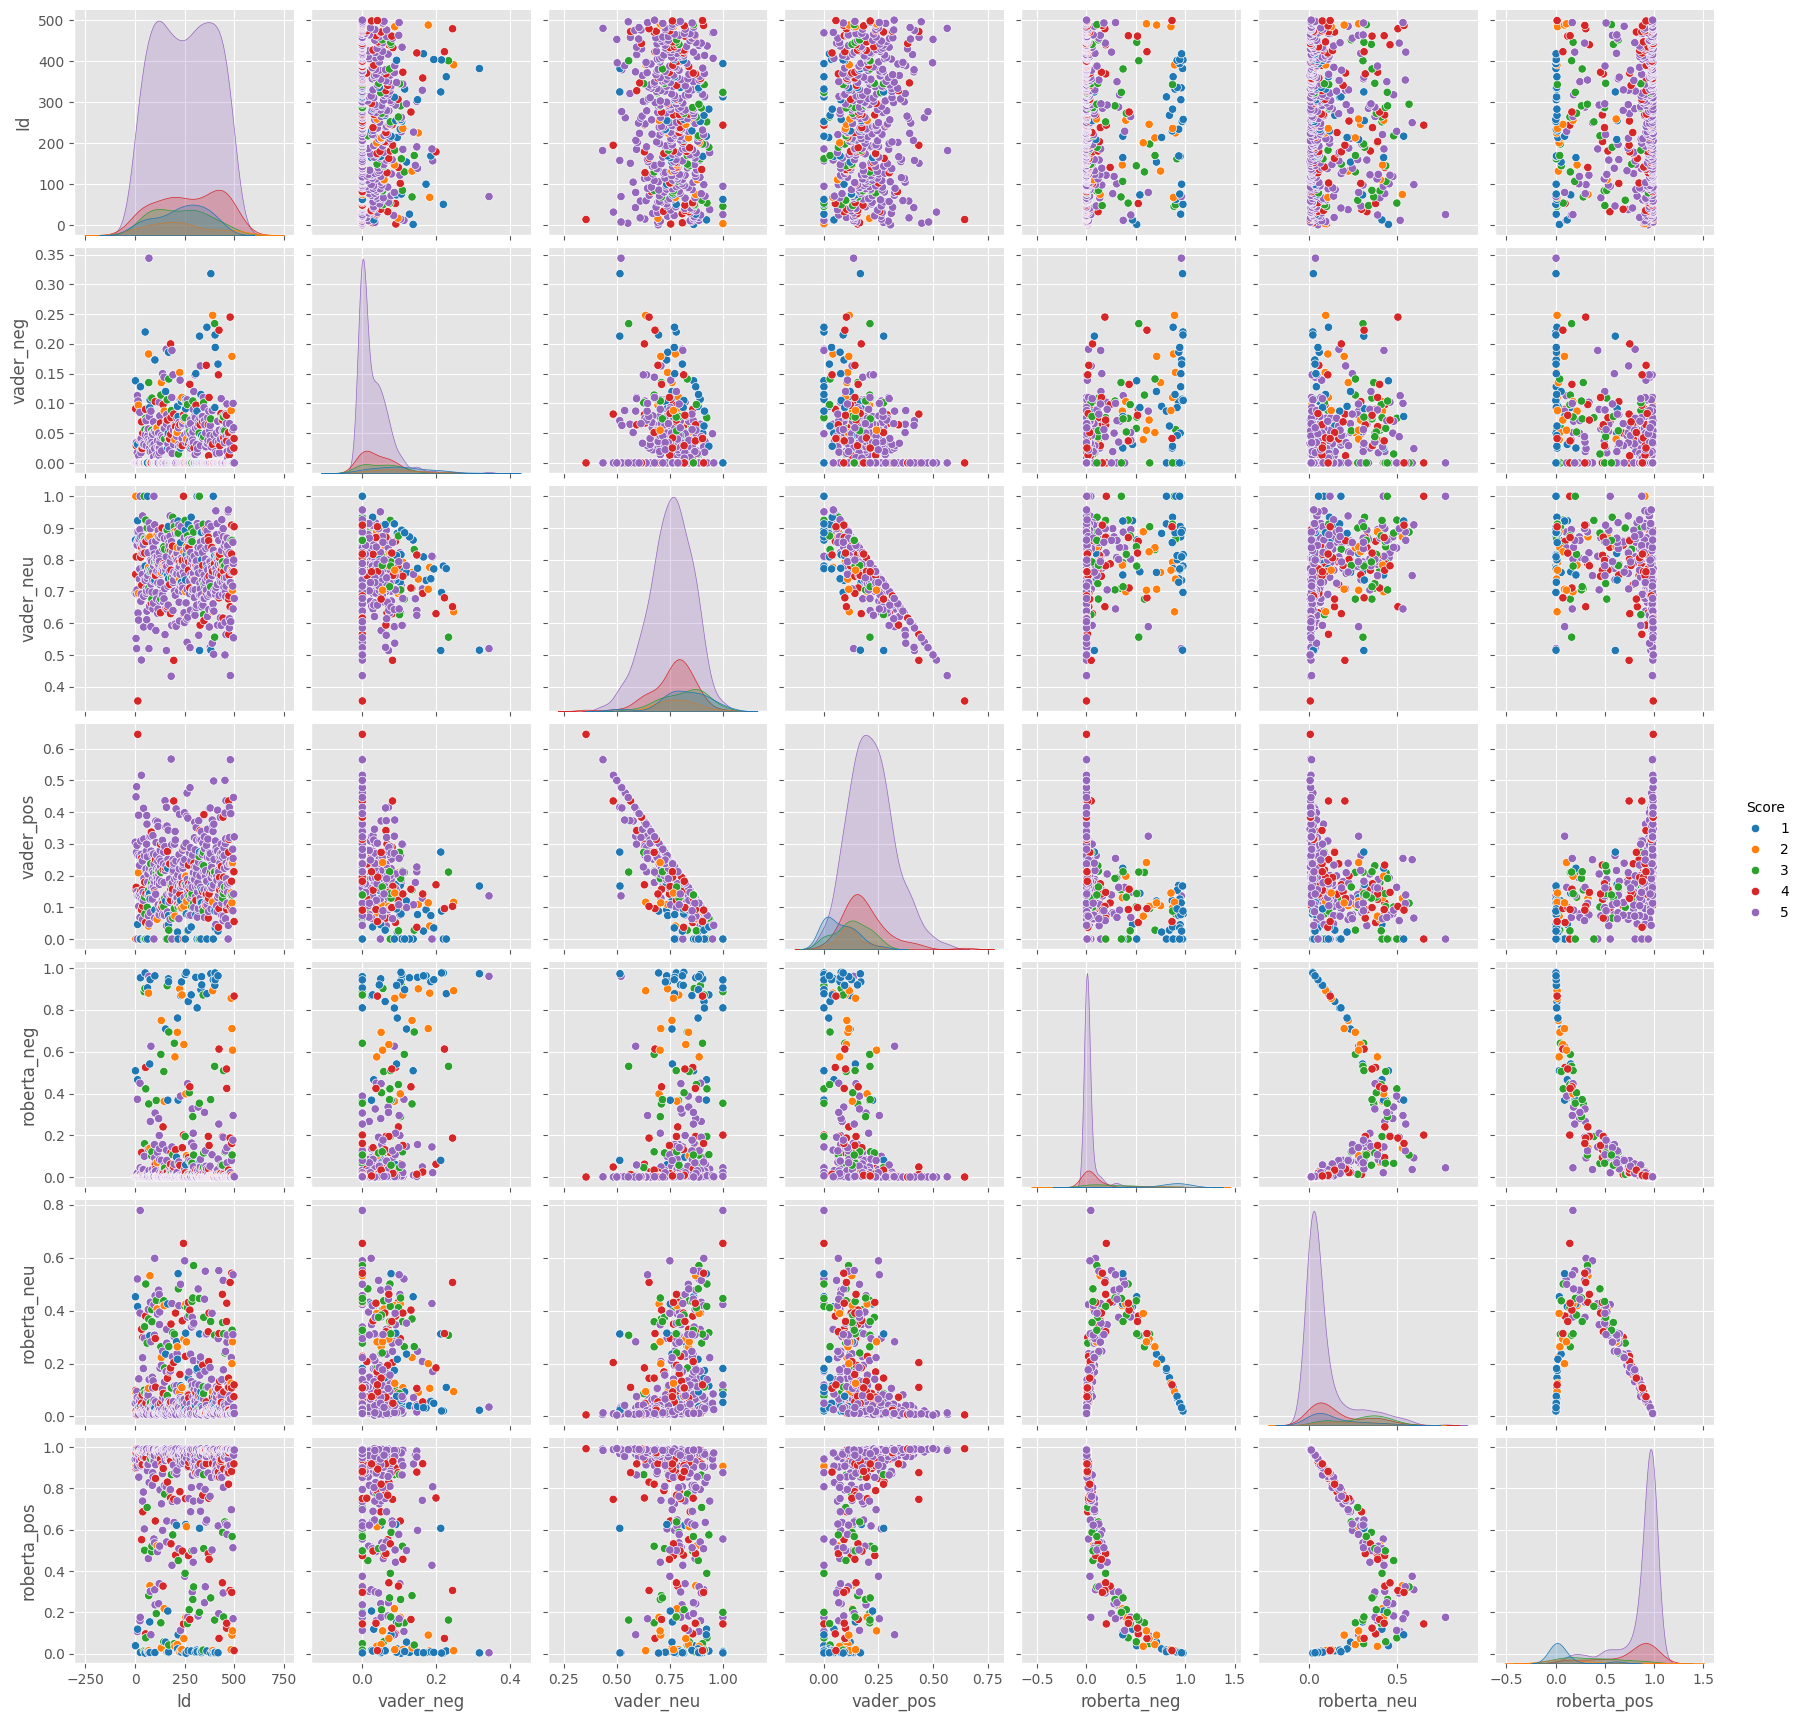

In [84]:
sns.pairplot(data=res_merged_reorder, vars=new_order, hue="Score", palette="tab10")
plt.show()

### Positive 1-Star Review

In [102]:
res_merged_reorder.query("Score == 1") \
                .sort_values("roberta_pos", ascending=False)["Text"].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [103]:
res_merged_reorder.query("Score == 1") \
                .sort_values("vader_pos", ascending=False)["Text"].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

### Negative 5-Star review

In [104]:
res_merged_reorder.query("Score == 5") \
                .sort_values("roberta_neg", ascending=False)["Text"].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [105]:
res_merged_reorder.query("Score == 5") \
                .sort_values("vader_neg", ascending=False)["Text"].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

## Transformers Pipeline

In [107]:
from transformers import pipeline

In [108]:
sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu


In [109]:
sent_pipeline("I love sentiment analysis")

[{'label': 'POSITIVE', 'score': 0.999736487865448}]

In [111]:
sent_pipeline("wat da hell man")

[{'label': 'NEGATIVE', 'score': 0.9874101281166077}]